In [1]:
import numpy as np
import random
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
import sklearn
import pandas as pd
from sklearn.ensemble import RandomForestClassifier


### Data information
The features are numerical. There are 569 samples with 30 features. The classes are binary (0 or 1). 

Highly varying scales (feature 9 is in range (0.001, 0.02), while feature 23 is in range (185, 4254)) -> should be scaled and centered.

Slightly imbalanced -> 357 0s and 212 1s.

In [2]:
# Load UCI breast cancer dataset with column names and remove ID column
uci_bc_data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data", 
    sep=",",
    header=None,
    names=[
        "id_number", "diagnosis", "radius_mean",
        "texture_mean", "perimeter_mean", "area_mean",
        "smoothness_mean", "compactness_mean",
        "concavity_mean","concave_points_mean",
        "symmetry_mean", "fractal_dimension_mean",
        "radius_se", "texture_se", "perimeter_se",
        "area_se", "smoothness_se", "compactness_se",
        "concavity_se", "concave_points_se",
        "symmetry_se", "fractal_dimension_se",
        "radius_worst", "texture_worst",
        "perimeter_worst", "area_worst",
        "smoothness_worst", "compactness_worst",
        "concavity_worst", "concave_points_worst",
        "symmetry_worst", "fractal_dimension_worst"
    ],).drop("id_number", axis=1)

y = uci_bc_data.diagnosis.map({"B": 0, "M": 1}).to_numpy()
X = uci_bc_data.drop("diagnosis", axis=1).to_numpy()

verbose = 0
if verbose:
    for i in range(31):
        print('Feature {} in range {}:{}'.format(i, np.amin(X[:,i]), np.amax(X[:,i])))

    print(len(np.argwhere(y == 0)))
    print(len(np.argwhere(y == 1)))


### Rescale and center

In [3]:
Xmax = np.amax(X,0)
Xmin = np.amin(X,0)
Xnew = (X-Xmin)/(Xmax - Xmin)*2 - 1

verbose = 0
if verbose:
    for i in range(31):
        print('Feature {} in range {}:{}'.format(i, np.amin(Xnew[:,i]), np.amax(Xnew[:,i])))


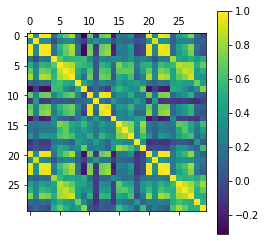

In [4]:
df = pd.DataFrame(Xnew)
correlation_matrix = np.array(df.corr())
verbose = 1
if verbose:
    corr = df.corr()
    plt.matshow(df.corr())
    plt.colorbar()
    plt.show()
    


### Correlation
Some of the features are highly correlated. The reason for this is biological, as features like radius, perimeter, and area must be highly correlated. 

Ground correlation matrix:


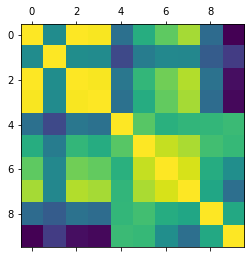

Estimated correlation matrix for class label 0:


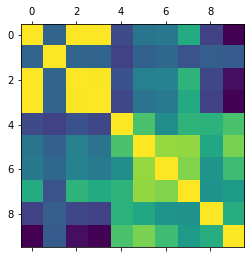

Estimated correlation matrix for class label 1:


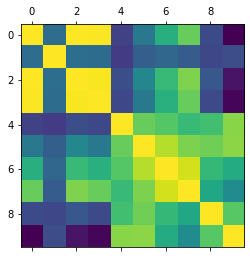

In [5]:
def get_correlation_matrix(cov_matrix):
    diag = np.diag(cov_matrix)
    diag = np.sqrt(1/diag)
    D = np.diag(diag)
    correlation_matrix = D@cov_matrix@D
    return correlation_matrix

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

clf = QuadraticDiscriminantAnalysis(store_covariance = True)
clf.fit(X,y)
covariance_est = clf.covariance_
correlation_est_0 = get_correlation_matrix(clf.covariance_[0])
correlation_est_1 = get_correlation_matrix(clf.covariance_[1])
print('Ground correlation matrix:')
plt.matshow(correlation_matrix[:10,:10])
plt.show()
print('Estimated correlation matrix for class label 0:')
plt.matshow(correlation_est_0[:10,:10])
plt.show()
print('Estimated correlation matrix for class label 1:')
plt.matshow(correlation_est_1[:10,:10])
plt.show()




### Split data

In [6]:
def split_data(X,y):
    indices = list(range(len(y)))
    random.shuffle(indices)
    split_index = int(0.8*len(y))
    train_indices = indices[:split_index]
    test_indices = indices[split_index:]
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    return X_train, y_train, X_test, y_test

### Metric choice
Recall is a good classification metric, as it is more important to detect positives than negatives.

In [7]:
def get_operating_characteristics(y_pred, y, verbose = 0):
    TP = np.sum(np.logical_and(y_pred, y))
    TN = np.sum(np.logical_and(y_pred == 0, y == 0))
    FP = np.sum(np.logical_and(y_pred, y == 0))
    FN = np.sum(np.logical_and(y_pred == 0, y))

    Tot = TP+TN+FP+FN
    TP = TP/Tot
    TN = TN/Tot
    FP = FP/Tot
    FN = FN/Tot
    T = 1


    accuracy = (TP + TN)/T
    recall = (TP)/(TP+FN)
    specificity = TN/(TN+FP)
    precision = TP/(TP + FP)
    F1 = 2*precision*recall/(precision + recall)
    MCC = (TP*TN - FP*FN)/(np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)))
    
    if verbose:
        print('Accuracy is {:.2f}.'.format(accuracy))
        print('Recall is {:.2f}.'.format(recall))
        print('Specificity is {:.2f}.'.format(specificity))
        print('Precision is {:.2f}.'.format(precision))
        print('F1 is {:.2f}.'.format(F1))
        print('MCC is {:.2f}.'.format(MCC))
    return accuracy,recall, specificity, precision, F1, MCC


### Train and evaluate QDA and random forest

In [8]:
def evaluate_model(model_constructor, X, y, n_runs, split_data_function):
    accuracy_array = np.zeros(n_runs)
    recall_array = np.zeros(n_runs)
    specificity_array = np.zeros(n_runs)
    precision_array = np.zeros(n_runs)
    F1_array = np.zeros(n_runs)
    MCC_array = np.zeros(n_runs)
    for i in range(n_runs):
        X_train, y_train, X_test, y_test = split_data_function(X,y)
        fit = model_constructor()
        fit.fit(X_train,y_train)
        y_pred = fit.predict(X_test)
        accuracy,recall, specificity, precision, F1, MCC = get_operating_characteristics(y_pred, y_test)
        accuracy_array[i] = accuracy
        recall_array[i] = recall
        specificity_array[i] = specificity
        precision_array[i] = precision
        F1_array[i] = F1
        MCC_array[i] = MCC
    return accuracy_array, recall_array, specificity_array, precision_array, F1_array, MCC_array

In [9]:
n_runs = 50
accuracy_array, recall_array, specificity_array, precision_array, F1_array, MCC_array = evaluate_model(QuadraticDiscriminantAnalysis, X,y, n_runs, split_data) 

print('QDA ({} runs):'.format(n_runs))
print('Average accuracy: {:.2f}, standard deviation: {:.4f}.'.format(np.mean(precision_array), np.std(precision_array)))
print('Average recall: {:.2f}, standard deviation: {:.4f}.'.format(np.mean(recall_array), np.std(recall_array)))
print('Average F1: {:.2f}, standard deviation: {:.4f}.\n'.format(np.mean(F1_array), np.std(F1_array)))

accuracy_array, recall_array, specificity_array, precision_array, F1_array, MCC_array = evaluate_model(RandomForestClassifier, X,y, n_runs, split_data) 

print('Random forest ({} runs):'.format(n_runs))
print('Average accuracy: {:.2f}, standard deviation: {:.4f}.'.format(np.mean(precision_array), np.std(precision_array)))
print('Average recall: {:.2f}, standard deviation: {:.4f}.'.format(np.mean(recall_array), np.std(recall_array)))
print('Average F1: {:.2f}, standard deviation: {:.4f}.'.format(np.mean(F1_array), np.std(F1_array)))

QDA (50 runs):
Average accuracy: 0.93, standard deviation: 0.0401.
Average recall: 0.94, standard deviation: 0.0332.
Average F1: 0.94, standard deviation: 0.0283.

Random forest (50 runs):
Average accuracy: 0.96, standard deviation: 0.0294.
Average recall: 0.92, standard deviation: 0.0412.
Average F1: 0.94, standard deviation: 0.0246.


### Test stratification

In [11]:
def split_data_stratification(X,y):
    n_0 = len(np.argwhere(y == 0))
    n_1 = len(np.argwhere(y == 1))

    indices = np.array(range(len(y)))
    random.shuffle(indices)
    indices_0 = indices[[int(x) for x in list(np.argwhere(y == 0))]]
    indices_1 = indices[[int(x) for x in list(np.argwhere(y == 1))]]

    split_index_0 = int(n_0*0.8)
    train_indices_0 = indices_0[:split_index_0]
    test_indices_0 = indices_0[split_index_0:]

    split_index_1 = int(n_1*0.8)
    train_indices_1 = indices_1[:split_index_1]
    test_indices_1 = indices_1[split_index_1:]

    X_train = X[np.append(train_indices_0, train_indices_1)]
    y_train = y[np.append(train_indices_0, train_indices_1)]

    X_test = X[np.append(test_indices_0, test_indices_1)]
    y_test = y[np.append(test_indices_0, test_indices_1)]
    
    return X_train, y_train, X_test, y_test

In [12]:
n_runs = 50
accuracy_array, recall_array, specificity_array, precision_array, F1_array, MCC_array = evaluate_model(QuadraticDiscriminantAnalysis, X,y, n_runs, split_data_stratification) 

print('QDA ({} runs):'.format(n_runs))
print('Average accuracy: {:.2f}, standard deviation: {:.4f}.'.format(np.mean(precision_array), np.std(precision_array)))
print('Average recall: {:.2f}, standard deviation: {:.4f}.'.format(np.mean(recall_array), np.std(recall_array)))
print('Average F1: {:.2f}, standard deviation: {:.4f}.\n'.format(np.mean(F1_array), np.std(F1_array)))

accuracy_array, recall_array, specificity_array, precision_array, F1_array, MCC_array = evaluate_model(RandomForestClassifier, X,y, n_runs, split_data_stratification) 

print('Random forest ({} runs):'.format(n_runs))
print('Average accuracy: {:.2f}, standard deviation: {:.4f}.'.format(np.mean(precision_array), np.std(precision_array)))
print('Average recall: {:.2f}, standard deviation: {:.4f}.'.format(np.mean(recall_array), np.std(recall_array)))
print('Average F1: {:.2f}, standard deviation: {:.4f}.'.format(np.mean(F1_array), np.std(F1_array)))

QDA (50 runs):
Average accuracy: 0.93, standard deviation: 0.0320.
Average recall: 0.94, standard deviation: 0.0324.
Average F1: 0.94, standard deviation: 0.0239.

Random forest (50 runs):
Average accuracy: 0.95, standard deviation: 0.0299.
Average recall: 0.93, standard deviation: 0.0409.
Average F1: 0.94, standard deviation: 0.0257.
